## Example, Cart Pole, DQN (Deep Q-learning Network)

#### Even though this is a "basic bare bones" -implementation of DQN, it is still quite complicated when compared to classical Q-learning. Read carefully through the comments and explanations to help you compare DQN to classical Q-learning.

In [1]:
# imports
import gymnasium as gym
import numpy as np
from collections import deque

# display management
from IPython.display import clear_output
from IPython.utils import io

import os
os.environ['KERAS_BACKEND'] = "torch"

# we are going to need keras and TORCH in this example
# pip install keras
# pip install torch==2.5.1

import keras
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Create environment

In [2]:
# create environment (you can see the details of observation and action space in the documentation)
# https://gymnasium.farama.org/environments/classic_control/cart_pole/
env = gym.make("CartPole-v1")

# we need these later with q-network input-layer
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [3]:
# I make first experiment by 50 episode and 1000 episode also compare the results with 500 episodes.
# With the 50 episdoe the agent has just started learning, so it isn’t doing very well yet. Its performance is still low, not getting high rewards. The results change a lot because it hasn’t trained enough. It’s still trying out different actions and hasn’t figured out the best way to do things.
# while with 500 episods, The agent has learned well, gets high rewards, works steadily, and mostly uses what it knows.
# Inshort
# With 50 episodes, training time is short, learning is incomplete, and performance is not very good. The rewards change a lot, the agent is mostly exploring, and its policy is not well learned
# With 500 episodes, training time is longer, learning is more complete, and performance is much better. The rewards are more steady, the agent balances exploring and using what it learned, and its policy is well learned.

# with 1000 episode, the agent learns a better policy. Epsilon drops to 0.015 after a few hundred episodes, so it uses what it learned more. It often gets rewards over 200 and can reach 500. Updating the target network every 128 steps keeps training stable.
# If epsilon drops too early, the agent may overfit to certain behaviors. A replay buffer of 1000 can lose useful past data during long training. Running 1000 episodes with 500 steps each takes a lot of time and compute. After a few hundred episodes, improvements is slow down.
# The agent achive the solved Cart Pole in 558 episodes with total steps 17855 and obtained total reward  1000.0

In [ ]:
# Further experiment by changing Parameters and then lets see the results also I am telling you why i am changing the parameters.
# I am changing ( replay_buffer_capacity = 5000) because small replay buffer makes the agent forget useful past events too soon, hurting learning. A bigger buffer keeps more varied memories, helping the agent learn better and more steadily.
# Then (epsilon_decay = 0.999) A slower decay rate means the agent keeps exploring longer. This helps it avoid choosing a bad solution too soon.
# (target_step_update_interval = 256) Updating the target network less often gives more stable goals for learning. This can help the agent learn more steadily and do better


In [ ]:
# Lets see the results 
#  shows clear graphs for loss, reward, and variance improvements over the examples code results that i took from cours's git folder. By changing paramaters it also tracks how stable the agent is with more reward trend details. Printouts after each episode help you see how training is going.
# By the use DQN with experience and  a target network. This experiment shows steady learning with better rewards and lower variance.
# Shows increasing average reward over time. Episode rewards converge toward the max (500), indicating successful balancing of the pole.
# It seems to generalize well, with low variance late in training. its also seems not overfitting.
# But surprisingly Loss graph graph shows loss going up over time, which means the model is learning poorly or getting unstable. It may be due to a high learning rate or a training issue.
# variance graph also showing that variance increases steadily over time, suggesting growing instability or variability during training—likely in a reinforcement learning setup. This could mean the model's behavior or rewards are becoming more unpredictable as learning progresses.
#  Rewards per episode over time in a reinforcement learning setting, where the average reward generally increases but with high fluctuations, indicating the agent is learning but still behaves inconsistently or explores unstable strategies.

# Over all i am not satisfy with this experiment by many changes, lets change few parametere only and see the agent behaviour and check the loss and reward matrix.

# By changing episode, steps, and 2 other paratmers, Agent learn very well and achive the goal with Total Reward: 1000.0 within 558 episode and in 145528 steps.

### DQN hyperparameters

In [5]:
# hyperparameters
gamma = 0.99
epsilon = 1.0

# remember: Cart Pole is extremely sensitive to inputs
# you probably need a very low epsilon in the end of the training
epsilon_min = 0.015

# in DQN-networks we usually use a MULTIPLIER -version of decay
# after each episode => multiply epsilon with 0.99 etc. instead 
# reducing the epsilon with a constant step-by-step reduction like 0.00025
epsilon_decay = 0.9925

# neural network-specific hyperparameters
# please note: this is the neural network learning rate
# we are going to skip the Q-learning learning rate because of this
learning_rate = 0.01

# this is the target "goal" of our agent
# if the agent is able to play the environment for 350 steps WITHOUT failing => win the game
max_steps = 500

# similar to usual neural network batch size
# the bigger the batch size, the faster the training and vice versa
# by default, batch size should not affect the quality of the training
# but in case of reinforcement learning, we'll have to double-check
batch_size = 32 

# "max epochs" -> episodes are basically the epochs of reinforcement learning
max_episodes = 1000

# replay buffer capacity: usually simple environments work with small capacities 
# (1000-5000), more complex environments are usually 10000+ in capacity size
buffer_capacity = 5000

# Q-network and target network parameters
# train_steps => how often the Q-network values are updated
q_network_train_step_interval = 3

# how often the target network values are updated
target_step_update_interval = 128

### Basic DQN replay buffer is usually more or less like this

In [6]:
# Replay buffer / experience replay -class
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity

        # list that stores the experiences
        self.buffer = []

         # pointer to the current position in the buffer
        self.position = 0

    # if the buffer is full, the new experience will overwrite the oldest experience
    def store(self, experience): 
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = experience

        # update the position pointer
        self.position = (self.position + 1) % self.capacity 
        
    # randomly sample a batch of experiences for our DQN
    def sample(self, batch_size): 
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)

### Build the neural networks (Q-network + target network)

In [7]:
# make a helper function to build a q-network
def build_q_network():
    # basic idea => observations go in, actions come out
    # you can adjust the details of the network as you wish
    # have more layers, more nodes etc. most of the same things
    # we used already in Deep Learning
    model = Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_dim,)),
        layers.Dense(action_dim, activation='linear')
    ])

    # compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="mse")
    return model

# initialize Q-network AND the target network
q_network = build_q_network()

# we use the same "blueprint" for the target network as the q-network
# because is essentially a reference network to q-network
target_network = build_q_network()

# SYNCHRONIZE the initial state between both networks -> IMPORTANT STEP
# otherwise the networks have different starting points
# and the target network is not very helpful as a reference for the q-network
target_network.set_weights(q_network.get_weights())

# INITIALIZE the replay buffer
replay_buffer = ReplayBuffer(buffer_capacity)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Helper functions: epsilon function + train step -function

In [8]:
# helper function for handling the epsilon (exploration vs. exploitation)
# this basic epsilon implementation is known as "epsilon-greedy"
# compare this to the typical exploration/exploitation
# in previous FrozenLake and MountainCar, same principle
# different implementation
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        # take a random action -> exploration
        return np.random.choice(action_dim)
    
    # use the existing Q-values of the agent -> exploitation
    # we have to match the state's data format into neural network -format
    state = np.expand_dims(state, axis=0)

    # there's going to be lots of Keras/Torch -based extra message (output)
    # use io.capture_output() to suppress them
    with io.capture_output() as captured:
        # this is basically the same as getting the best value from the current
        # Q-table in classical Q-learning
        q_values = q_network.predict(state)

    # return best action decided by current model => either go left or right
    return np.argmax(q_values)


# training loop helper function for the DQN
# in your exercise project 3 => this is a very good function to study 
# in more detail, since this is basically the way how we can adapt
# the goals of reinforcement learning to work with basic neural networks as well
def train_step():
    # in the beginning of the training, we don't have enough data in
    # the buffer (compared to batch size), we'll have to wait
    if replay_buffer.size() < batch_size:
        return
    
    # if we have enough samples, we continue here
    batch = replay_buffer.sample(batch_size)

    # COMPARE THIS ON how we unpack the observation
    # in classical Q-learning, we just have a batch of observations this time
    states, actions, rewards, next_states, dones = batch

    # predict Q-values for the current and next state using the Q-network
    state_q_values = q_network.predict(states, verbose=0)
    next_state_q_values = target_network.predict(next_states, verbose=0)

    # take a copy of the state values so we can update them in the loop below
    targets = state_q_values.copy()

    # compute target q-values => basically same as Q-targets in Bellman/Q-learning -equation
    # BUT WITHOUT LEARNING RATE
    for i in range(batch_size):
        if dones[i]:
            targets[i, actions[i]] = rewards[i]
        else:
            # this is essentially the Bellman/Q-learning -equation, COMPARE TO EARLIER EXERCISES
            targets[i, actions[i]] = rewards[i] + gamma * np.max(next_state_q_values[i])

    # finally, update the Q-network based on the targets we just created 
    # "out of nowhere" -> from the past experiences in replay buffer
    with io.capture_output() as captured:
        loss = q_network.train_on_batch(states, targets)
        return loss

### Training loop (uses helper functions + replay buffer from earlier)

In [9]:
# initialize helper lists
losses = []
rewards = []
variances = []
reward_window = deque(maxlen=100)

all_rewards = []
running_mean_rewards = []
running_var_rewards = []
all_losses = []

total_steps = 0

for episode in range(max_episodes):
    state, info = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = select_action(state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)

        total_reward += reward
        total_steps += 1

        # store transition
        replay_buffer.store((state, action, reward, next_state, done))
        state = next_state

        # train the Q-network
        if total_steps % q_network_train_step_interval == 0:
            loss = train_step()
            all_losses.append(loss)
            losses.append(loss)

        # update the target network
        if total_steps % target_step_update_interval == 0:
            target_network.set_weights(q_network.get_weights())

        if done:
            break

    # update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # log metrics after each episode
    reward_window.append(total_reward)
    all_rewards.append(total_reward)

    running_mean = np.mean(reward_window)
    running_var = np.var(reward_window)

    running_mean_rewards.append(running_mean)
    running_var_rewards.append(running_var)
    rewards.append(total_reward)
    variances.append(np.var(rewards))

    print(f"Total steps: {total_steps}")
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

    if total_reward >= (max_steps - 5) and epsilon == epsilon_min:
        print(f"Solved Cart Pole in {episode + 1} episodes!")
        break


Total steps: 17
Episode 1: Total Reward = 17.00, Epsilon = 0.993
Total steps: 61
Episode 2: Total Reward = 44.00, Epsilon = 0.985
Total steps: 82
Episode 3: Total Reward = 21.00, Epsilon = 0.978
Total steps: 112
Episode 4: Total Reward = 30.00, Epsilon = 0.970
Total steps: 124
Episode 5: Total Reward = 12.00, Epsilon = 0.963
Total steps: 144
Episode 6: Total Reward = 20.00, Epsilon = 0.956
Total steps: 163
Episode 7: Total Reward = 19.00, Epsilon = 0.949
Total steps: 186
Episode 8: Total Reward = 23.00, Epsilon = 0.942
Total steps: 196
Episode 9: Total Reward = 10.00, Epsilon = 0.934
Total steps: 221
Episode 10: Total Reward = 25.00, Epsilon = 0.927
Total steps: 241
Episode 11: Total Reward = 20.00, Epsilon = 0.921
Total steps: 262
Episode 12: Total Reward = 21.00, Epsilon = 0.914
Total steps: 287
Episode 13: Total Reward = 25.00, Epsilon = 0.907
Total steps: 298
Episode 14: Total Reward = 11.00, Epsilon = 0.900
Total steps: 317
Episode 15: Total Reward = 19.00, Epsilon = 0.893
Total s

## Metrics (total rewards, running mean, variance over time, losses)

#### In the end of the day, in reinforcement learning applications, the actual performance of the agent matters most.

#### However, if the agent does not work well, metrics become useful then.

Variance over time


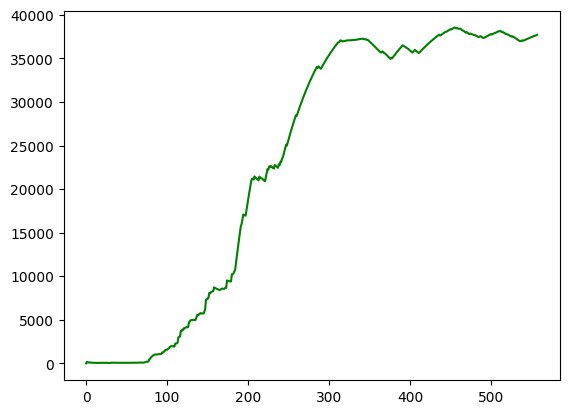

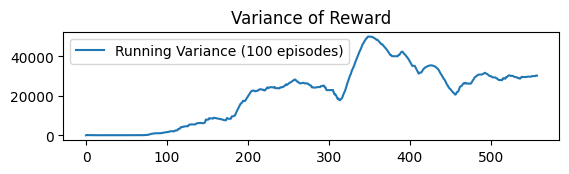

In [10]:
# visualize variance over time
print("Variance over time")
plt.plot(variances, color="green")
plt.show()

plt.subplot(3, 1, 2)
plt.plot(running_var_rewards, label='Running Variance (100 episodes)')
plt.title("Variance of Reward")
plt.legend()

# if variance rises but running mean doesn't, we might have an instability issue
# in this case, we usually need to adjust training parameters, hyperparameters (especially epsilon decay)
# or even the reward mechanism in the policy

Neural network losses over time


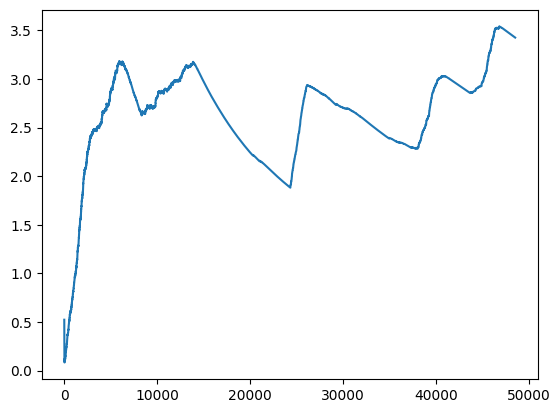

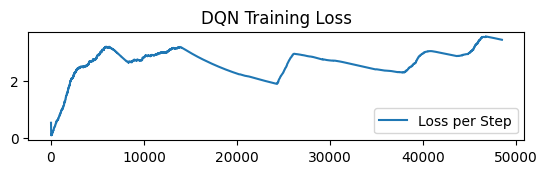

In [11]:
# visualize losses (neural network metrics)
print("Neural network losses over time")
plt.plot(losses)
plt.show() 

plt.subplot(3, 1, 3)
plt.plot(all_losses, label='Loss per Step')
plt.title("DQN Training Loss")
plt.legend()

# losses are as usual in neural networks => it can imply overfitting
# but it's also quite normal that the losses fluctuate even if the agent works well
# if agent does not work well => adjust hyperparameters, especially the learning rate

Rewards by episode


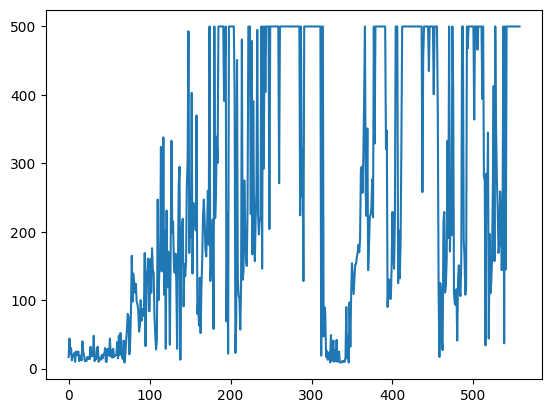

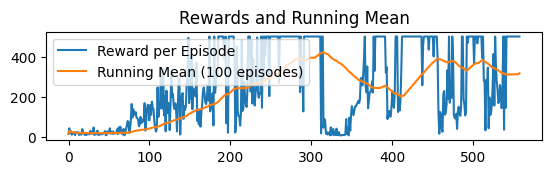

In [12]:
# let's see the rewards progression
print("Rewards by episode")
plt.plot(rewards)
plt.show()


plt.subplot(3, 1, 1)
plt.plot(all_rewards, label='Reward per Episode')
plt.plot(running_mean_rewards, label='Running Mean (100 episodes)')
plt.title("Rewards and Running Mean")
plt.legend()

Rewards w/ running mean:


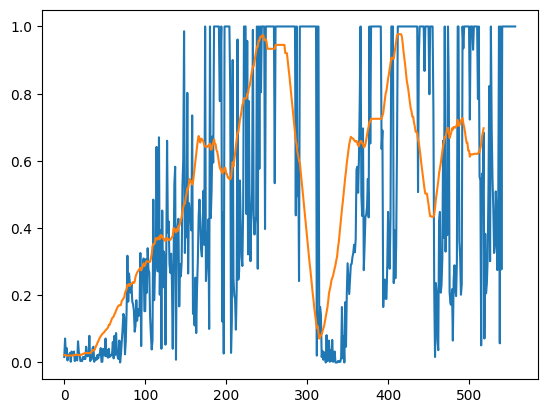

In [13]:
# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)

# define a window size for a moving average

# 50 is okay for 15000 episodes as the minimum window size
# if the running mean line is too noisy, adjust the window size
# rule of thumb: many episodes => bigger window_ize
# 15000 => 30-50 is okay for window size
window_size = 40

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

print("Rewards w/ running mean:")
# visualize rewards + RUNNING MEAN
plt.plot(normalized_rewards)
plt.plot(running_mean)
plt.show()

In [ ]:
#The blue line represents the raw, episode-by-episode reward — it’s noisy due to fluctuations in individual outcomes.
# Early on (episodes 0–100), rewards gradually increase, indicating the agent is learning.
# From episodes 100–300, there's a noticeable improvement, peaking around episode 250.
# A drop follows (around 300), possibly due to exploration or environment change.
# Performance rises again after 350, showing continued learning with fluctuations.

### Finally: test the DQN-agent in the Cart Pole -environment

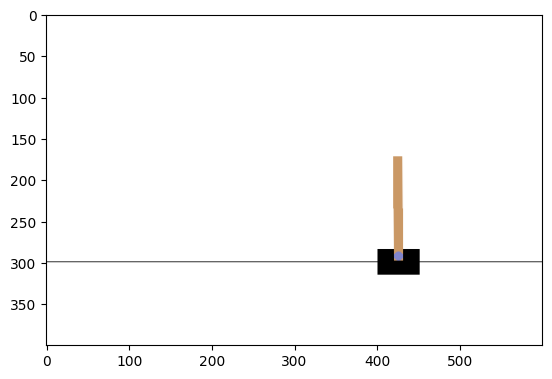

Total Reward: 1000.0


In [14]:
# make a new environment for the test
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
total_reward = 0

# play the environment
for step in range(1000):
    action = select_action(state, epsilon)
    state, reward, done, truncated, info = env.step(action)
    total_reward += reward

    # visualize frame
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    if done:
        break

# print result
print(f"Total Reward: {total_reward}")

# it plays pretty well already!